##### <a id="1"></a>
<font color="darkslateblue" size=+2.5><b>1. Libraries</b></font>

In [1]:

# Standard libraries
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
from collections import Counter
#import Image

# Viz libs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid.inset_locator import InsetPosition
#import folium
#from folium.plugins import HeatMap, FastMarkerCluster
#from wordcloud import WordCloud

# Geolocation libs
#from geopy.geocoders import Nominatim
# Utils modules
from custom_transformers import *
from viz_utils import *
from ml_utils import *

# ML libs
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
#import shap

In [2]:
from geopy.geocoders import Nominatim

In [3]:
!pip install geopy

In [4]:
!pip install lightgbm

<a id="1"></a>
<font color="darkslateblue" size=+2.5><b>2. Reading and Exploring the Data</b></font>

In [5]:
# Reading restaurants data
data_path = r'zomato.csv'
df_restaurants = import_data(path=data_path, n_lines=5000)

# Results
print(f'Dataset shape: {df_restaurants.shape}')
df_restaurants.head()

This dataset has 17 columns, which 1 is/are applicable to optimization.

----------------------------------------------------
Memory usage (5000 lines): 0.6486 MB
Memory usage after optimization (5000 lines): 0.6295 MB
----------------------------------------------------

Reduction of 2.94% on memory usage

Dataset shape: (51717, 17)


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


By looking at the dataset page on Kaggle, it's possible to see the meaning of each columns of the data. Just to allign the concepts, we have:

* **_url:_** contains the url of the restaurant in the zomato website;
* **_address:_** contains the address of the restaurant in Bengaluru;
* **_name:_** contains the name of the restaurant;
* **_online-order:_** whether online ordering is available in the restaurant or not;
* **_book-table:_** table book option available or not;
* **_rate:_** contains the overall rating of the restaurant out of 5;
* **_votes:_** contains total number of rating for the restaurant as of the above mentioned date;
* **_phone:_** contains the phone number of the restaurant;
* **_location:_** contains the neighborhood in which the restaurant is located;
* **_rest-type:_** restaurant type.

We don't have explanation for some columns like **_dish-liked_**, **_approx-cost(for two people)_** and others but its meaning can be extracted by looking at the dataset head above. As long as we look at those initial rows, we can see either the need of transformation on some columns like **_rate_** for example (we will talk about this in the future).

<a id="2.1"></a>
<font color="dimgrey" size=+2.0><b>2.1 Overview from the Data</b></font>



Once read the data, let's now use a homemade implementation to extract useful information about the dataset.

In [6]:
# An overview from the data
df_overview = data_overview(df_restaurants)
df_overview

,feature,qtd_null,percent_null,dtype,qtd_cat
0,dish_liked,28078,0.542916,object,5271
1,rate,7775,0.150337,object,64
2,phone,1208,0.023358,object,14926
3,approx_cost(for two people),346,0.006690,object,70
4,rest_type,227,0.004389,object,93
5,cuisines,45,0.000870,object,2723
6,location,21,0.000406,object,93
7,listed_in(type),0,0.000000,object,7
8,menu_item,0,0.000000,object,9098
9,reviews_list,0,0.000000,object,22513


<a id="2.2"></a>
<font color="dimgrey" size=+2.0><b>2.2 Initial Prep</b></font>


Well, after reading the data and taking a look at its characteristics, we can now do a hands on to apply some preparation steps. As we said right above, there are some columns that could be threated better. Let's point in topics we will do right now:

* **approx_cost(for two people):**
    - Change the data type from object to float;
    

* **rate:**
    - Let's eliminate the "/5" text and change data type from object to float

In [7]:
# Changing the data type from approx_cost columns
df_restaurants['approx_cost'] = df_restaurants['approx_cost(for two people)'].astype(str).apply(lambda x: x.replace(',',''))
df_restaurants['approx_cost'] = df_restaurants['approx_cost'].astype(float)

# Extracting the rate in a float column
df_restaurants['rate_num'] = df_restaurants['rate'].astype(str).apply(lambda x: x.split('/')[0])
while True:
    try:
        df_restaurants['rate_num'] = df_restaurants['rate_num'].astype(float)
        break
    except ValueError as e1:
        noise_entry = str(e1).split(":")[-1].strip().replace("'", "")
        print(f'Threating noisy entrance on rate: {noise_entry}')
        df_restaurants['rate_num'] = df_restaurants['rate_num'].apply(lambda x: x.replace(noise_entry, str(np.nan)))

# Dropping old columns
df_restaurants.drop(['approx_cost(for two people)', 'rate'], axis=1, inplace=True)
df_restaurants.head()

Threating noisy entrance on rate: NEW
Threating noisy entrance on rate: -


,url,address,name,online_order,book_table,votes,phone,location,rest_type,dish_liked,cuisines,reviews_list,menu_item,listed_in(type),listed_in(city),approx_cost,rate_num
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese","[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,800.0,4.1
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai","[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,800.0,4.1
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian","[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,800.0,3.8
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian","[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,300.0,3.7
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani","[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,600.0,3.8


<a id="3"></a>
<font color="darkslateblue" size=+2.5><b>3. Graphical Exploration</b></font>

In this session, let's present useful charts that could be used to get intuition about the data. We will divide the exploratory data analysis into topics to help the users take their own conclusions. In each topic, we will also try to purpose questions that can be answeared with some graphic or table analysis.

<a id="3.1"></a>
<font color="dimgrey" size=+2.0><b>3.1 Restaurants Overview</b></font>



In this topic, let's make an initial analysis on our data looking at restaurant's features presented in it.

___
* _How many types of restaurants we have?_
___

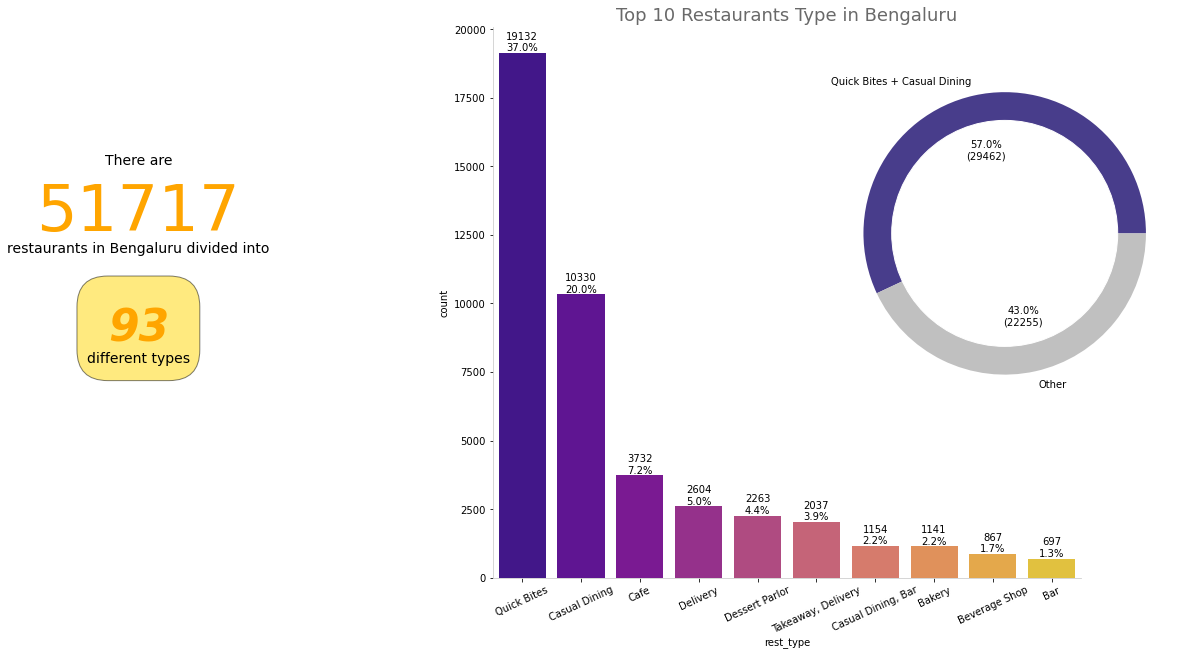

In [8]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(15, 9))

# Axis definition with GridSpec
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])

# Axis 1 - Big Number for total restaurants and total types in the data
total_restaurants = len(df_restaurants)
total_types = len(df_restaurants['rest_type'].value_counts())
ax1.text(0.00, 0.75, 'There are', fontsize=14, ha='center')
ax1.text(0.00, 0.63, f'{total_restaurants}', fontsize=64, color='orange', ha='center')
ax1.text(0, 0.59, 'restaurants in Bengaluru divided into', fontsize=14, ha='center')
ax1.text(0.00, 0.43, total_types, fontsize=44, ha='center', color='orange', style='italic', weight='bold',
         bbox=dict(facecolor='gold', alpha=0.5, pad=14, boxstyle='round, pad=.7'))
ax1.text(0, 0.39, 'different types', fontsize=14, ha='center')
ax1.axis('off')

# Axis 2 - Total number of restaurants per type (Top N)
top = 10
single_countplot(df_restaurants, ax2, x='rest_type', top=top)
ax2.set_title(f'Top {top} Restaurants Type in Bengaluru', color='dimgrey', size=18)
for tick in ax2.get_xticklabels():
    tick.set_rotation(25)
    
# Axis 3 - Representative of the top two restaurant type
df_restaurants['top_types'] = df_restaurants['rest_type'].apply(lambda x: 'Quick Bites + Casual Dining' if x in ('Quick Bites', 'Casual Dining') else 'Other')
ax3 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax2, [0.57, 0.3, 0.6, 0.65])
ax3.set_axes_locator(ip)
donut_plot(df_restaurants, col='top_types', ax=ax3, colors=['darkslateblue', 'silver'], title='')

___
* _What are the most popular restaurants?_
___

For answearing the question above, let's group our data into some numerical variables that could probably show a good overview from restaurant's indicators like `total votes`, `mean approx cost`, `rate` and others. By the end, we will have in hands a new DataFrame with grouped information about all the restaurant's franchise in the dataset.

It's important to say that here we are grouping by `restaurant name` and, as long as there are restaurants with the same name in the dataset (same name but different locations, for example), we will also see how many unities each "franchise" have.

In [9]:
popular_franchises = df_restaurants.groupby(by='name', as_index=False).agg({'votes': 'sum',
                                                                            'url': 'count',
                                                                            'approx_cost': 'mean',
                                                                            'rate_num': 'mean'})
popular_franchises.columns = ['name', 'total_votes', 'total_unities', 'mean_approx_cost', 'mean_rate_num']
popular_franchises['votes_per_unity'] = popular_franchises['total_votes'] / popular_franchises['total_unities']
popular_franchises = popular_franchises.sort_values(by='total_unities', ascending=False)
popular_franchises = popular_franchises.loc[:, ['name', 'total_unities', 'total_votes', 'votes_per_unity',
                                                'mean_approx_cost', 'mean_rate_num']]




popular_franchises.head(10)

,name,total_unities,total_votes,votes_per_unity,mean_approx_cost,mean_rate_num
1320,Cafe Coffee Day,96,3089,32.177083,844.791667,3.256977
5549,Onesta,85,347520,4088.470588,600.000000,4.410588
3788,Just Bake,73,2898,39.698630,400.000000,3.405970
2446,Empire Restaurant,71,229808,3236.732394,685.211268,4.030435
2577,Five Star Chicken,70,3134,44.771429,257.857143,3.425000
3958,Kanti Sweets,68,7336,107.882353,400.000000,3.898529
5790,Petoo,66,4242,64.272727,659.848485,3.833333
5840,Polar Bear,65,8121,124.938462,361.538462,4.031034
827,Baskin Robbins,64,2487,38.859375,251.562500,3.572581
1655,Chef Baker's,62,5073,81.822581,516.071429,3.590909


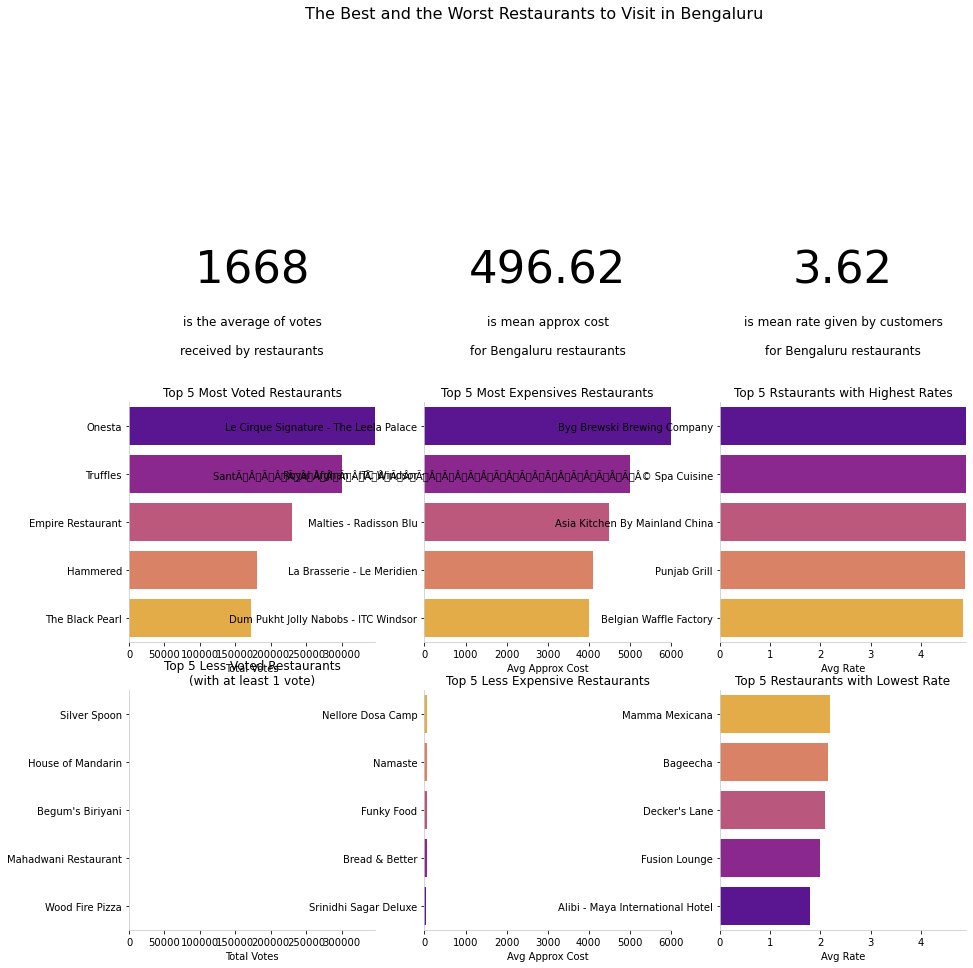

In [10]:
# Creating a figure por restaurants overview analysis
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Plot Pack 01 - Most popular restaurants (votes)
sns.barplot(x='total_votes', y='name', data=popular_franchises.sort_values(by='total_votes', ascending=False).head(),
            ax=axs[1, 0], palette='plasma')
axs[1, 0].set_title('Top 5 Most Voted Restaurants', size=12)
sns.barplot(x='total_votes', y='name', 
            data=popular_franchises.sort_values(by='total_votes', ascending=False).query('total_votes > 0').tail(),
            ax=axs[2, 0], palette='plasma_r')
axs[2, 0].set_title('Top 5 Less Voted Restaurants\n(with at least 1 vote)', size=12)
for ax in axs[1, 0], axs[2, 0]:
    ax.set_xlabel('Total Votes')
    ax.set_xlim(0, popular_franchises['total_votes'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 0].text(0.50, 0.30, int(popular_franchises.total_votes.mean()), fontsize=45, ha='center')
axs[0, 0].text(0.50, 0.12, 'is the average of votes', fontsize=12, ha='center')
axs[0, 0].text(0.50, 0.00, 'received by restaurants', fontsize=12, ha='center')
axs[0, 0].axis('off')

# Plot Pack 02 - Cost analysis
sns.barplot(x='mean_approx_cost', y='name', data=popular_franchises.sort_values(by='mean_approx_cost', ascending=False).head(),
            ax=axs[1, 1], palette='plasma')
axs[1, 1].set_title('Top 5 Most Expensives Restaurants', size=12)
sns.barplot(x='mean_approx_cost', y='name', 
            data=popular_franchises.sort_values(by='mean_approx_cost', ascending=False).query('mean_approx_cost > 0').tail(),
            ax=axs[2, 1], palette='plasma_r')
axs[2, 1].set_title('Top 5 Less Expensive Restaurants', size=12)
for ax in axs[1, 1], axs[2, 1]:
    ax.set_xlabel('Avg Approx Cost')
    ax.set_xlim(0, popular_franchises['mean_approx_cost'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 1].text(0.50, 0.30, round(popular_franchises.mean_approx_cost.mean(), 2), fontsize=45, ha='center')
axs[0, 1].text(0.50, 0.12, 'is mean approx cost', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.00, 'for Bengaluru restaurants', fontsize=12, ha='center')
axs[0, 1].axis('off')

# Plot Pack 03 - Rate analysis
sns.barplot(x='mean_rate_num', y='name', data=popular_franchises.sort_values(by='mean_rate_num', ascending=False).head(),
            ax=axs[1, 2], palette='plasma')
axs[1, 2].set_title('Top 5 Rstaurants with Highest Rates', size=12)
sns.barplot(x='mean_rate_num', y='name', 
            data=popular_franchises.sort_values(by='mean_rate_num', ascending=False).query('mean_rate_num > 0').tail(),
            ax=axs[2, 2], palette='plasma_r')
axs[2, 2].set_title('Top 5 Restaurants with Lowest Rate', size=12)
for ax in axs[1, 2], axs[2, 2]:
    ax.set_xlabel('Avg Rate')
    ax.set_xlim(0, popular_franchises['mean_rate_num'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 2].text(0.50, 0.30, round(popular_franchises.mean_rate_num.mean(), 2), fontsize=45, ha='center')
axs[0, 2].text(0.50, 0.12, 'is mean rate given by customers', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.00, 'for Bengaluru restaurants', fontsize=12, ha='center')
axs[0, 2].axis('off')

plt.tight_layout()
plt.suptitle('The Best and the Worst Restaurants to Visit in Bengaluru', size=16)
plt.show()

<a id="3.2"></a>
<font color="dimgrey" size=+2.0><b>3.2 Restaurants Services</b></font>



Well, with the chart above we purpose a really good look at the Bengaluru scenario: we chose three numerical features (total votes, mean approx cost and rate). Now let's use other useful features of our dataset to understand how these numerical features can be changed along the services restaurants offers, like `book table` and `online order`.

___
* _How many restaurants offer Book Table service? And how about Online Order service?_
___

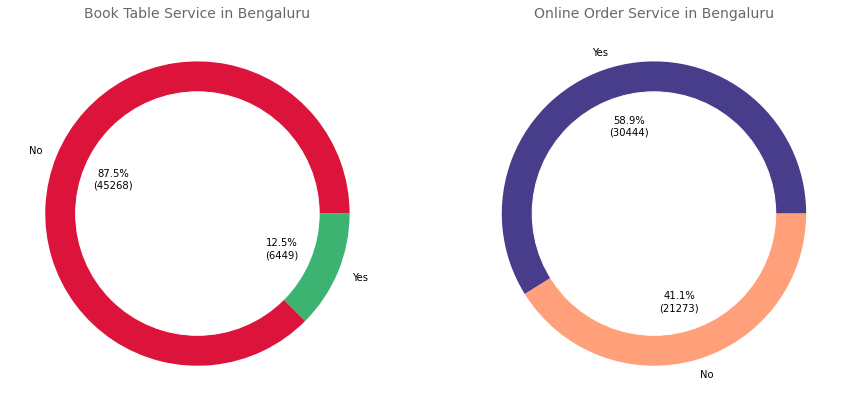

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
donut_plot(df_restaurants, col='book_table', colors=['crimson', 'mediumseagreen'], ax=axs[0], 
           title='Book Table Service in Bengaluru')
donut_plot(df_restaurants, col='online_order', colors=['darkslateblue', 'lightsalmon'], ax=axs[1], 
           title='Online Order Service in Bengaluru')

With the donuts above we can clearly see the proportions of Bengaluru restaurants who offers book table and online order service. In the first case, we can see that just 12.5% of restaurants have book table, while 87.5% don't offer this service.

By the other hand, we have almost 59% of restaurants who have online order service.

___
* _How the offering of Book Table service impact on Rate and Approx Cost?_
___

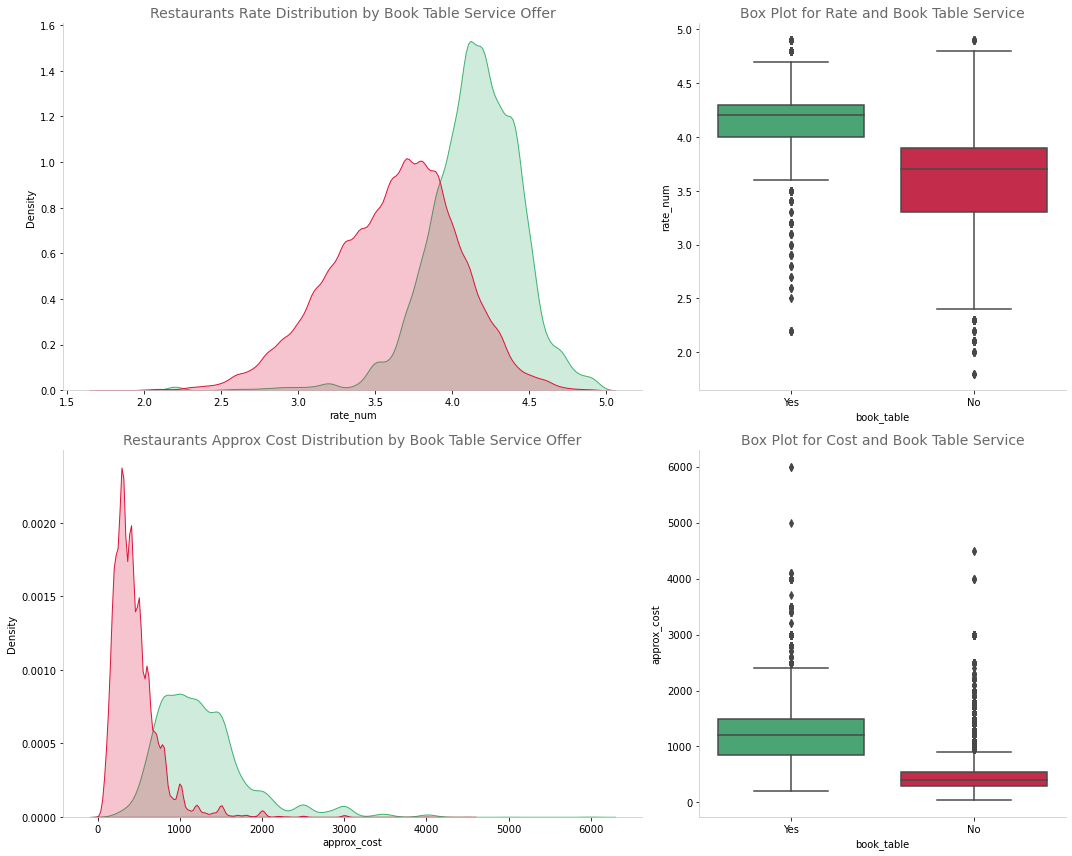

In [12]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition with GridSpec
gs = GridSpec(2, 5, figure=fig)
ax2 = fig.add_subplot(gs[0, :3])
ax3 = fig.add_subplot(gs[0, 3:])
ax4 = fig.add_subplot(gs[1, :3])
ax5 = fig.add_subplot(gs[1, 3:])

# First Line (01) - Rate
sns.kdeplot(df_restaurants.query('rate_num > 0 & book_table == "Yes"')['rate_num'], ax=ax2,
             color='mediumseagreen', shade=True, label='With Book Table Service')
sns.kdeplot(df_restaurants.query('rate_num > 0 & book_table == "No"')['rate_num'], ax=ax2,
             color='crimson', shade=True, label='Without Book Table Service')
ax2.set_title('Restaurants Rate Distribution by Book Table Service Offer', color='dimgrey', size=14)
sns.boxplot(x='book_table', y='rate_num', data=df_restaurants, palette=['mediumseagreen', 'crimson'], ax=ax3)
ax3.set_title('Box Plot for Rate and Book Table Service', color='dimgrey', size=14)

# First Line (01) - Cost
sns.kdeplot(df_restaurants.query('approx_cost > 0 & book_table == "Yes"')['approx_cost'], ax=ax4,
             color='mediumseagreen', shade=True, label='With Book Table Service')
sns.kdeplot(df_restaurants.query('approx_cost > 0 & book_table == "No"')['approx_cost'], ax=ax4,
             color='crimson', shade=True, label='Without Book Table Service')
ax4.set_title('Restaurants Approx Cost Distribution by Book Table Service Offer', color='dimgrey', size=14)
sns.boxplot(x='book_table', y='approx_cost', data=df_restaurants, palette=['mediumseagreen', 'crimson'], ax=ax5)
ax5.set_title('Box Plot for Cost and Book Table Service', color='dimgrey', size=14)


# Customizing plots
for ax in [ax2, ax3, ax4, ax5]:
    format_spines(ax, right_border=False)
    
plt.tight_layout()

The distplot and the boxplot above show us the importance given by the customers for book table service in restaurants: on the first line we notice that, in general, restaurants with book table service usually receive highest rate notes. Meanwhile, we can conclude by the second line that those same restaurants are usually more expensive.

___
* _How the offering of Online Order service impact on Rate and Approx Cost?_
___

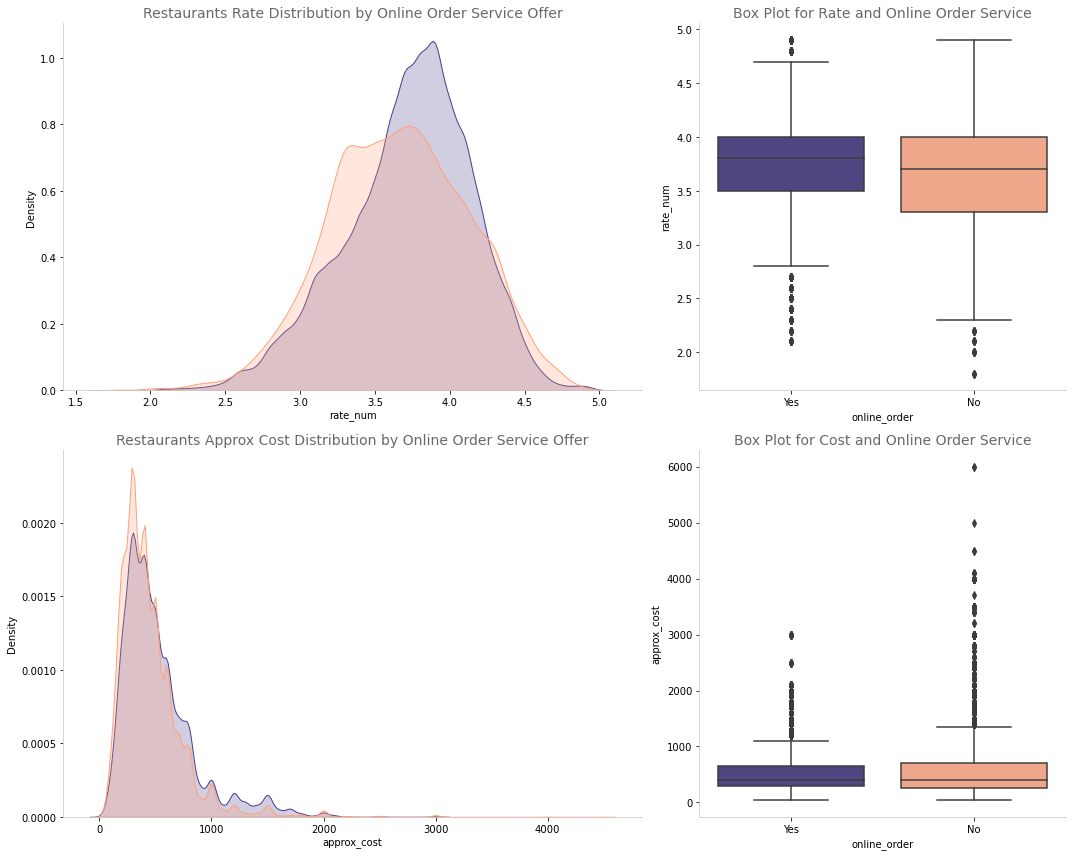

In [13]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition with GridSpec
gs = GridSpec(2, 5, figure=fig)
ax2 = fig.add_subplot(gs[0, :3])
ax3 = fig.add_subplot(gs[0, 3:])
ax4 = fig.add_subplot(gs[1, :3])
ax5 = fig.add_subplot(gs[1, 3:])

# First Line (01) - Rate
sns.kdeplot(df_restaurants.query('rate_num > 0 & online_order == "Yes"')['rate_num'], ax=ax2,
             color='darkslateblue', shade=True, label='With Online Order Service')
sns.kdeplot(df_restaurants.query('rate_num > 0 & online_order == "No"')['rate_num'], ax=ax2,
             color='lightsalmon', shade=True, label='Without Online Order Service')
ax2.set_title('Restaurants Rate Distribution by Online Order Service Offer', color='dimgrey', size=14)
sns.boxplot(x='online_order', y='rate_num', data=df_restaurants, palette=['darkslateblue', 'lightsalmon'], ax=ax3)
ax3.set_title('Box Plot for Rate and Online Order Service', color='dimgrey', size=14)

# First Line (01) - Cost
sns.kdeplot(df_restaurants.query('approx_cost > 0 & online_order == "Yes"')['approx_cost'], ax=ax4,
             color='darkslateblue', shade=True, label='With Online Order Service')
sns.kdeplot(df_restaurants.query('approx_cost > 0 & book_table == "No"')['approx_cost'], ax=ax4,
             color='lightsalmon', shade=True, label='Without Online Order Service')
ax4.set_title('Restaurants Approx Cost Distribution by Online Order Service Offer', color='dimgrey', size=14)
sns.boxplot(x='online_order', y='approx_cost', data=df_restaurants, palette=['darkslateblue', 'lightsalmon'], ax=ax5)
ax5.set_title('Box Plot for Cost and Online Order Service', color='dimgrey', size=14)


# Customizing plots
for ax in [ax2, ax3, ax4, ax5]:
    format_spines(ax, right_border=False)
    
plt.tight_layout()

Now if we look for online order service, it's fair to say that the customer don't give importance for this service as much they give for book table one. The rate distribution shows customers usually give highest rates for restaurants who offer online order service (even if the difference is little).

Looking at the cost comparison between restaurants who offer online order service, we can conclude that they are almost the same.

<a id="3.3"></a>
<font color="dimgrey" size=+2.0><b>3.3 Where Are the Good Ones?</b></font>



Searching for useful insights for maybe predicting the success of a restaurant in Bengaluru, let's dive into locations to answear the question in the session title. By the way, where are the good restaurants?*

_*Good restaurants are relative and we will point that the the good ones have a high rate_

In [14]:
# Grouping data into location
good_ones = df_restaurants.groupby(by='location', as_index=False).agg({'votes': 'sum',
                                                                       'url': 'count',
                                                                       'approx_cost': 'mean',
                                                                       'rate_num': 'mean'})
good_ones.columns = ['location', 'total_votes', 'total_unities', 'mean_approx_cost', 'mean_rate_num']
good_ones['votes_per_unity'] = good_ones['total_votes'] / good_ones['total_unities']
good_ones = good_ones.sort_values(by='total_unities', ascending=False)
good_ones = good_ones.loc[:, ['location', 'total_unities', 'total_votes', 'votes_per_unity',
                                                'mean_approx_cost', 'mean_rate_num']]
good_ones.head(10)

,location,total_unities,total_votes,votes_per_unity,mean_approx_cost,mean_rate_num
0,BTM,5124,619376,120.877440,396.480973,3.573740
22,HSR,2523,499720,198.065795,475.610048,3.672164
45,Koramangala 5th Block,2504,2219506,886.384185,663.663845,4.005821
29,JP Nagar,2235,586593,262.457718,522.771300,3.675306
89,Whitefield,2144,466829,217.737407,598.152836,3.621618
27,Indiranagar,2083,1196007,574.175228,653.788027,3.828154
32,Jayanagar,1926,488080,253.416407,476.407716,3.780280
56,Marathahalli,1846,445201,241.170639,513.750683,3.541927
3,Bannerghatta Road,1630,219077,134.403067,443.679654,3.507449
6,Bellandur,1286,206027,160.207621,527.503888,3.525692


Looking forward to put those numbers into a beautiful chart, let's use a homemade function called `answear_plot()` created to simulate the same analysis made for the best and worst restaurants in Bengaluru. This function can be found at the `viz_utils.py` module.

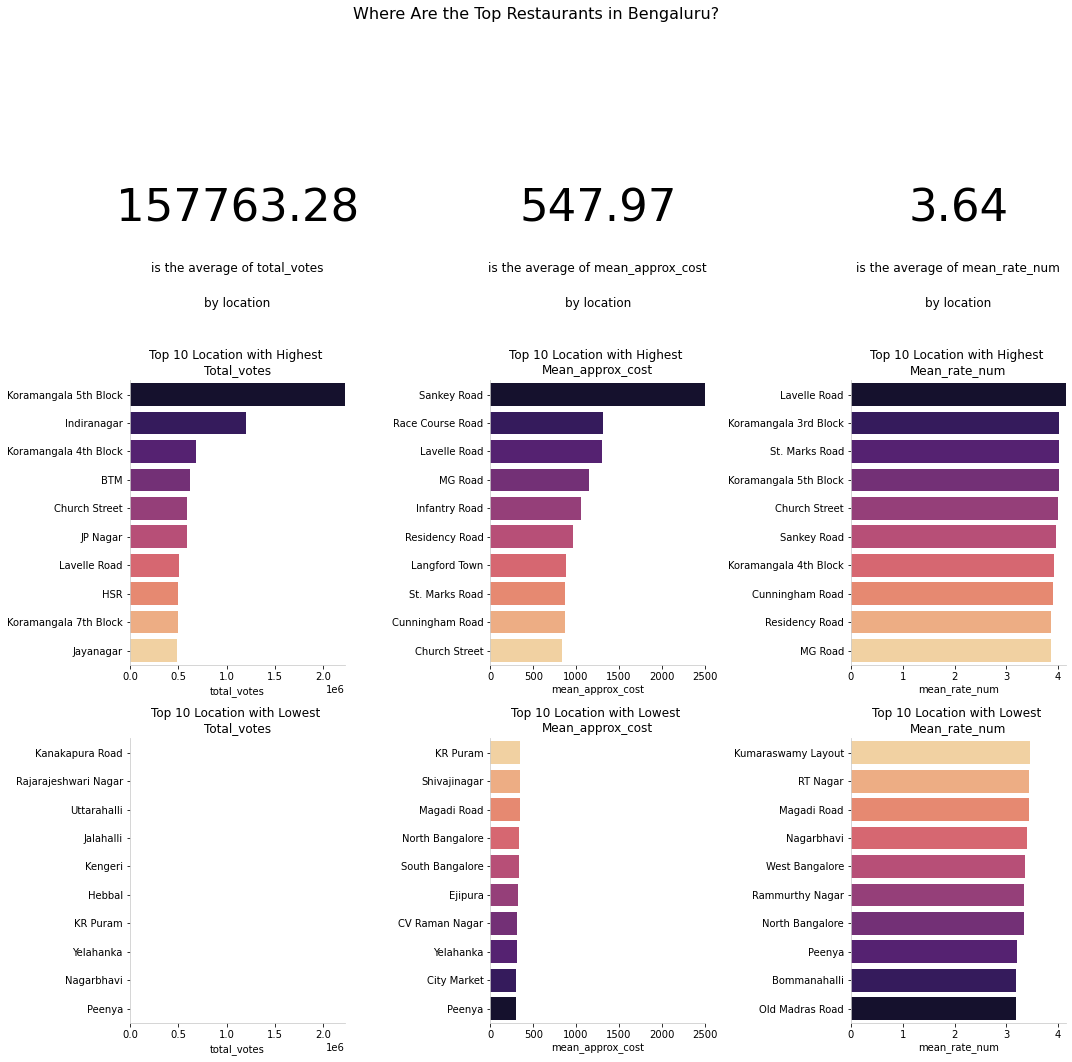

In [15]:
# Creating a figure por restaurants overview analysis
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
list_cols = ['total_votes', 'mean_approx_cost', 'mean_rate_num']

# PLotting best and worst by grouped data
answear_plot(grouped_data=good_ones, grouped_col='location', axs=axs, list_cols=list_cols, top=10, palette='magma')

# Finishing the chart
plt.suptitle('Where Are the Top Restaurants in Bengaluru?', size=16)
plt.tight_layout()
plt.show()

Now let's purpose a clearly view for cities with restaurants in Bengaluru and take a look at the average cost and rate of restaurants in each one. The idea is to see how these two variables are related and to present customers the insight of choosing the best city to visit (eating purposes) in Bengaluru.

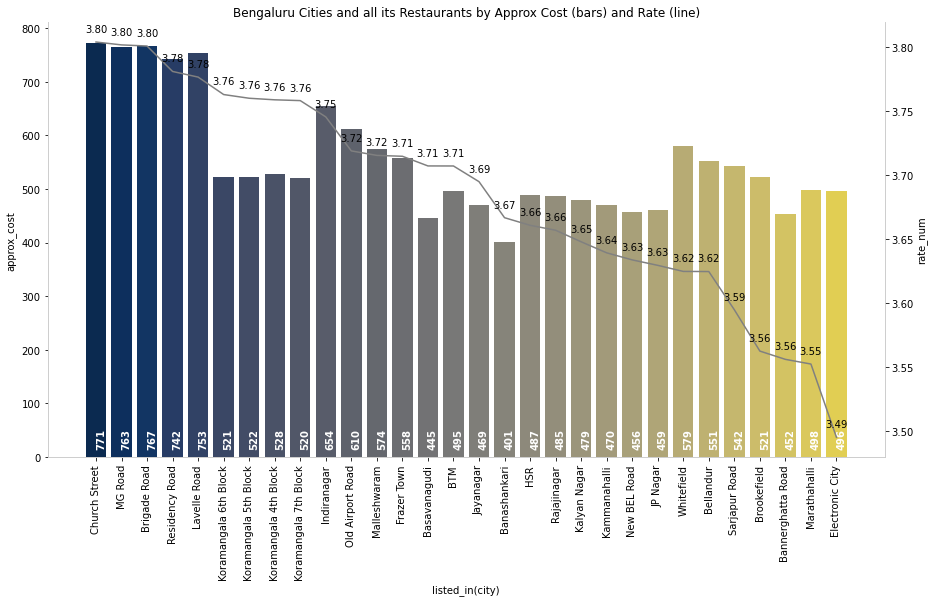

In [16]:
# Grouping data by city
city_group = df_restaurants.groupby(by='listed_in(city)', as_index=False).agg({'rate_num': 'mean',
                                                                               'approx_cost': 'mean'})
city_group.sort_values(by='rate_num', ascending=False, inplace=True)

# Ploting
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='listed_in(city)', y='approx_cost', data=city_group, palette='cividis', 
            order=city_group['listed_in(city)'])
ax2 = ax.twinx()
sns.lineplot(x='listed_in(city)', y='rate_num', data=city_group, color='gray', ax=ax2, sort=False)

# Labeling line chart (rate)
xs = np.arange(0, len(city_group), 1)
ys = city_group['rate_num']
for x,y in zip(xs, ys):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 color='black')
    
# Labeling bar chart (cost)
for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{}'.format(int(y)), (x.mean(), 15), va='bottom', rotation='vertical', color='white', 
                fontweight='bold')

# Customizing chart
format_spines(ax)
format_spines(ax2)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Bengaluru Cities and all its Restaurants by Approx Cost (bars) and Rate (line)')
plt.show()

In the following steps, the real idea was to extract lat and long features from the address in the dataset, but there are huge differences between address formats that made it difficult. So, maybe the best we can do here is to extract geolocation features based in the restaurant city. 

Of course this is not the best approach in terms of location precision, but I think is the best we can do regarding on the problems in the dataset address column construction . Let's use the `Nominatim` API to help us doing this job. I'll let my user_agent open.

In [17]:
# Extracting lat and long from the restaurant city using an API service
geolocator = Nominatim(user_agent="Y_BzShFZceZ_rj_t-cI13w")

# Creating a auxiliar dataset with cities location (reducing the API calls and time consuming by consequence)
cities_aux = pd.DataFrame(df_restaurants['listed_in(city)'].value_counts())
cities_aux.reset_index(inplace=True)
cities_aux.columns = ['city', 'total_restaurants']

# Extracting cities lat and long features
cities_aux['lat'] = cities_aux['city'].apply(lambda x: geolocator.geocode(x)[1][0])
cities_aux['lng'] = cities_aux['city'].apply(lambda x: geolocator.geocode(x)[1][1])

# Adding more features do further analysis
city_group = df_restaurants.groupby(by='listed_in(city)', as_index=False).agg({'votes': 'sum',
                                                                               'approx_cost': 'mean',
                                                                               'rate_num': 'mean'})
city_group.columns = ['city', 'total_votes', 'avg_approx_cost', 'avg_rate_num']

# Creating an unique city data
cities_aux = cities_aux.merge(city_group, how='left', on='city')

# Merging the original data to the grouped cities lat and long
df_restaurants = df_restaurants.merge(cities_aux, how='left', left_on='listed_in(city)', right_on='city')
df_restaurants.drop(['city', 'total_restaurants'], axis=1, inplace=True)

# Results on cities grouped data
cities_aux

,city,total_restaurants,lat,lng,total_votes,avg_approx_cost,avg_rate_num
0,BTM,3279,45.954851,-112.496595,985690,495.485145,3.707241
1,Koramangala 7th Block,2938,12.930264,77.633258,1065901,520.497598,3.758410
2,Koramangala 5th Block,2836,12.934377,77.628415,1040312,522.979026,3.760255
3,Koramangala 4th Block,2779,12.934334,77.630406,992065,528.353924,3.759035
4,Koramangala 6th Block,2623,12.930756,77.622658,978900,521.340524,3.763153
5,Jayanagar,2371,27.643927,83.052805,563880,469.077053,3.694969
6,JP Nagar,2096,12.265594,76.646540,395852,459.774904,3.629472
7,Indiranagar,1860,12.973291,77.640467,781831,654.753655,3.745659
8,Church Street,1827,40.713334,-74.009208,687895,771.990104,3.804262
9,MG Road,1811,12.975526,77.606790,722679,763.987696,3.802023


___
* _Geo Analysis: where are the restaurants located in Bengaluru?_
___

___
* _Heat Map: where are the restaurants with high average rate?_
___

Well, as I said before, this map vision session have low precision because we get the latitude and longitude information using the cities instead of the address. Again, we did this way because it was difficult to parse all the addresses in this dataset and also because of API's free tier time consuming and total requests limitations.

Even so, it's fair to say that some good information was delivered on the maps above. You can improve it by bringing precision geolocation information to this zomato dataset.

<a id="3.4"></a>
<font color="dimgrey" size=+2.0><b>3.4 Zomato Customers Preferences</b></font>



Let's take a closer look into the type of restaurants in this zomato dataset. The idea is to see if there is some preference in zomato orders.

___
* _How the rate and approx cost are distributed among restaurant types?_
___

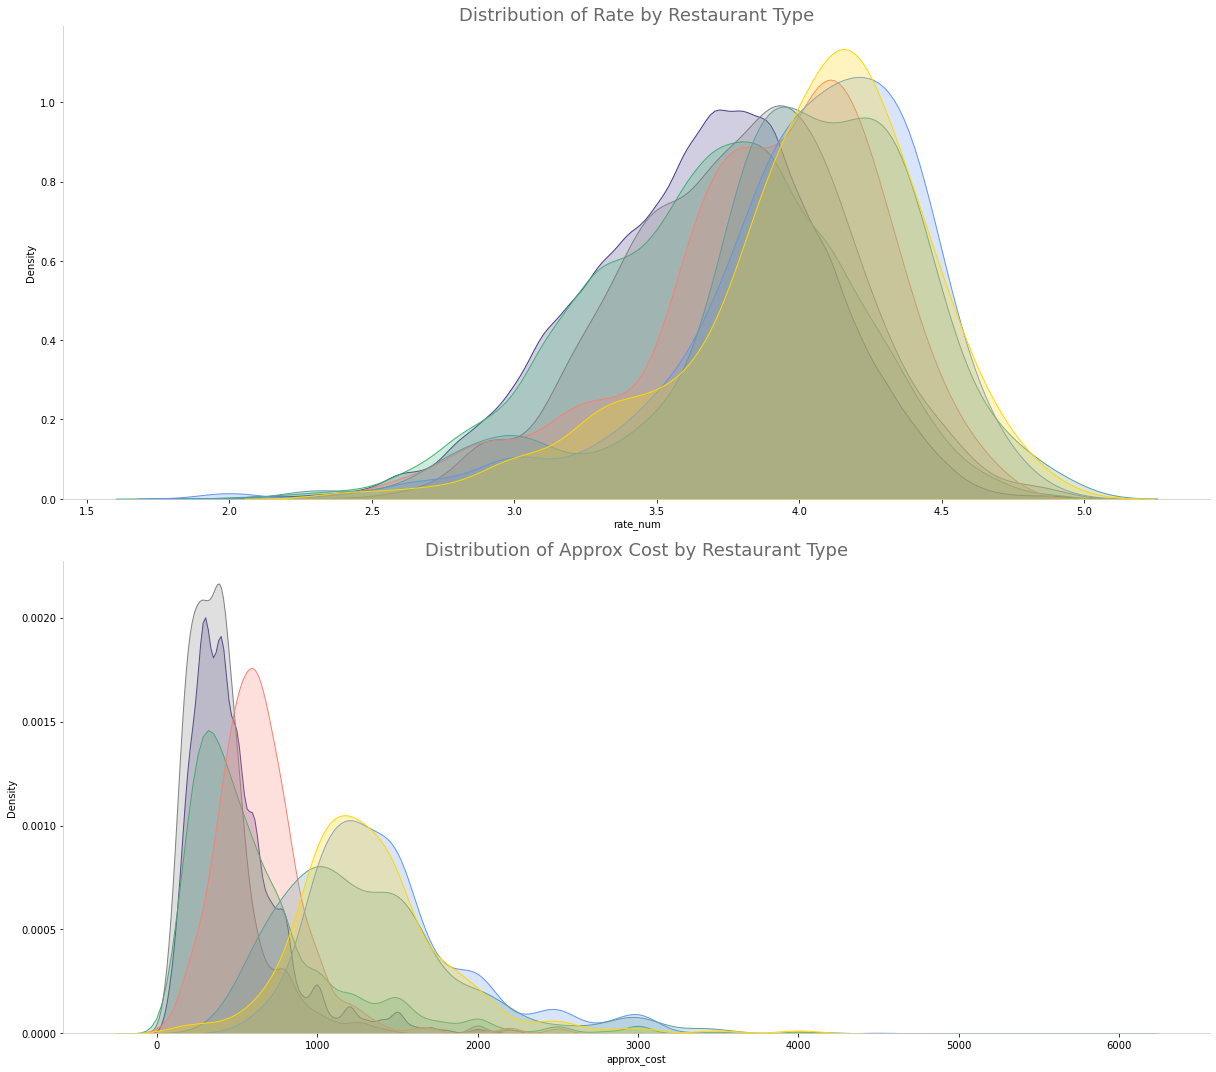

In [18]:
rest_types = list(df_restaurants['listed_in(type)'].value_counts().index)
colors = ['darkslateblue', 'mediumseagreen', 'gray', 'salmon', 'cornflowerblue', 'cadetblue', 'gold']

fig, axs = plt.subplots(2, 1, figsize=(17, 15))
for r_type in rest_types:
    idx = rest_types.index(r_type)
    kde_data = df_restaurants[(df_restaurants['rate_num'] > 0) & (df_restaurants['listed_in(type)'] == r_type)]
    sns.kdeplot(kde_data['rate_num'], ax=axs[0], color=colors[idx], shade=True, label=r_type)
    sns.kdeplot(kde_data['approx_cost'], ax=axs[1], color=colors[idx], shade=True, label=r_type)

# Customizing charts
axs[0].set_title('Distribution of Rate by Restaurant Type', color='dimgrey', size=18)
axs[1].set_title('Distribution of Approx Cost by Restaurant Type', color='dimgrey', size=18)
for ax in axs:
    format_spines(ax, right_border=False)
plt.tight_layout()

<a id="3.5"></a>
<font color="dimgrey" size=+2.0><b>3.5 Food Options</b></font>



In this session we will discuss the customer's food preferences. The goal is to go trough the text presented in the columns like `cuisines` and `dish_liked` to extract valuable information about options available in Bengaluru set of restaurants.

___
* _What we can conclude about main options available on Bengaluru restaurants?_
___

For answearing this question, let's do a text mining on `cuisine` column fo extract single options for each restaurant. After that, we will plot a WordCloud to see trends on food options.

In [19]:
#from wordcloud import WordCloud

In [20]:
# Creating a list with all options available
cuisines = list(df_restaurants['cuisines'].astype(str).values)
cuisines_word_list = []
for lista in [c.split(',') for c in cuisines]:
    for word in lista:
        cuisines_word_list.append(word.strip())
        
# Creating a Counter for unique options and generating the wordcloud
cuisines_wc_dict = Counter(cuisines_word_list)

wordcloud = WordCloud(width=1280, height=720, collocations=False, random_state=42, 
                      colormap='magma', background_color='white').generate_from_frequencies(cuisines_wc_dict)

# Visualizing the WC created and the total for each cuisine
fig, axs = plt.subplots(1, 2, figsize=(20, 12))
ax1 = axs[0]
ax2 = axs[1]
ax1.imshow(wordcloud)
ax1.axis('off')
ax1.set_title('WordCloud for Cuisines Available on Bengaluru Restaurants', size=18, pad=20)

# Total for each cuisine
df_cuisines = pd.DataFrame()
df_cuisines['cuisines'] = cuisines_wc_dict.keys()
df_cuisines['amount'] = cuisines_wc_dict.values()
df_cuisines.sort_values(by='amount', ascending=False, inplace=True)
sns.barplot(x='cuisines', y='amount', data=df_cuisines.head(10), palette='magma', ax=ax2)
format_spines(ax2, right_border=False)
ax2.set_title('Top 10 Cuisines in Bengaluru Restaurants', size=18)

# Customizing chart
ncount = df_cuisines['amount'].sum()
x_ticks = [item.get_text() for item in ax2.get_xticklabels()]
ax2.set_xticklabels(x_ticks, rotation=45, fontsize=14)
for p in ax2.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax2.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), fontsize=14, ha='center', va='bottom')

plt.tight_layout()
plt.show()

NameError: name 'WordCloud' is not defined

We can see a lot of North Indian, Chinese, South Indian, Fast Food, Desserts and other patterns related to options available in Bengaluru area. Good! Let's apply the same approach on `dish_liked` column to see if there are more trends.

<a id="4"></a>
<font color="darkslateblue" size=+2.5><b>4. Predicting the Success of a Restaurant</b></font>

Well, finally we arrived at our main task on this notebook: predict the success of a restaurant in Bengaluru using the data provided and extracting some additional features. At this point probably you're asking: but how we will do it? That's what a thought for this task:

    1. Use the restaurant rate to classify our data in two classes: good and bad (thresholds to be defined)
    2. Create a target variable using a pre-defined rate threshold
    3. Extract features from the data
    4. Create a classification model using a supervisioned approach
    5. Predict the "probability for being a good restaurant" for the ones marked as NEW or without rate
    
First of all, let's split the data we will use for train/validation and the data we want to do a real prediction.

<a id="4.1"></a>
<font color="dimgrey" size=+2.0><b>4.1 Target Definition</b></font>



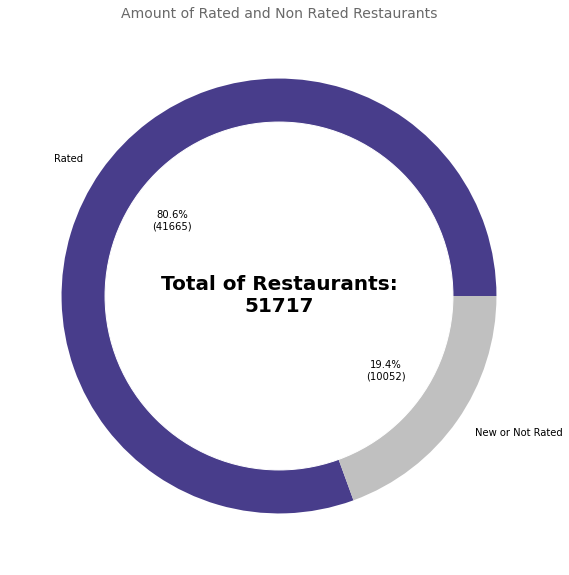

In [22]:
# Splitting restaurants
df_restaurants['rated'] = df_restaurants['rate_num'].apply(lambda x: 1 if x >= 0 else 0)
new_restaurants = df_restaurants.query('rated == 0')
train_val_restaurants = df_restaurants.query('rated == 1')

# PLotting a donut chart for seeing the distribution
fig, ax = plt.subplots(figsize=(10, 10))
donut_plot(df_restaurants, col='rated', ax=ax, label_names=['Rated', 'New or Not Rated'], 
           colors=['darkslateblue', 'silver'], title='Amount of Rated and Non Rated Restaurants',
           text=f'Total of Restaurants:\n{len(df_restaurants)}')

By now we've already splitted our original data into `new_restaurants` and `train_val_restaurants` pandas DataFrames. Let's keep the first one aside for now and let's work only with the training and validation set. The next step is to create our target variable to be used in this classification task.

The main point here is to define a fair threshold for splitting the restaurants into `good` and `bad` ones. It would be a really experimental decision and we must keep in mind that this approach is not the best one. Probably it would let margin for classification errors. Even so, let's try!

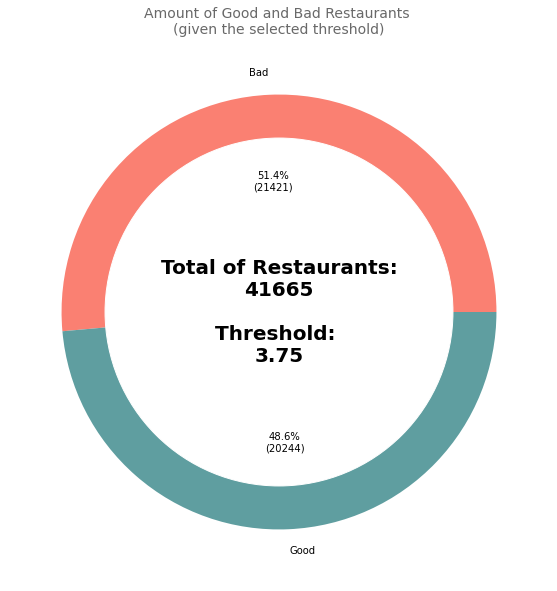

In [23]:
# Defining a custom threshold for splitting restaurants into good and bad
threshold = 3.75
train_val_restaurants['target'] = train_val_restaurants['rate_num'].apply(lambda x: 1 if x >= threshold else 0)

# Donut chart
fig, ax = plt.subplots(figsize=(10, 10))
label_names = ['Bad' if target == 0 else 'Good' for target in train_val_restaurants['target'].value_counts().index]
color_list = ['salmon' if label == 'Bad' else 'cadetblue' for label in label_names]
donut_plot(train_val_restaurants, col='target', ax=ax, label_names=label_names, 
           colors=color_list, title='Amount of Good and Bad Restaurants \n(given the selected threshold)',
           text=f'Total of Restaurants:\n{len(train_val_restaurants)}\n\nThreshold: \n{threshold}')

Ok, for our first trial it's fair. The meaning of all this is that we marked as `good` restaurants with a rate greather or ewual **3.75**. Correct or not, let's continue to see what we can get from this.

The next step is to prepare some features for training our classification model.

<a id="4.2"></a>
<font color="dimgrey" size=+2.0><b>4.2 Feature Extraction</b></font>


After defining the target and splitting the data into train+val and test sets, let's define the features to be used on training. Here we will take a look at the raw data to select valuable features and apply some steps to create another ones.

The initial set of selected features inclue:
    - online_order;
    - book_table;
    - location;
    - rest_type;
    - cuisines;
    - listed_in(type);
    - listed_in(city);
    - approx_cost

In [24]:
# Selecting initial features
initial_features = ['online_order', 'book_table', 'location', 'rest_type', 'cuisines', 
                    'listed_in(type)', 'listed_in(city)', 'approx_cost', 'target']
train_val_restaurants = train_val_restaurants.loc[:, initial_features]

# Extracting new features
train_val_restaurants['multiple_types'] = train_val_restaurants['rest_type'].astype(str).apply(lambda x: len(x.split(',')))
train_val_restaurants['total_cuisines'] = train_val_restaurants['cuisines'].astype(str).apply(lambda x: len(x.split(',')))

# Dropping another ones
train_val_restaurants.drop('cuisines', axis=1, inplace=True)
train_val_restaurants.head()

,online_order,book_table,location,rest_type,listed_in(type),listed_in(city),approx_cost,target,multiple_types,total_cuisines
0,Yes,Yes,Banashankari,Casual Dining,Buffet,Banashankari,800.0,1,1,3
1,Yes,No,Banashankari,Casual Dining,Buffet,Banashankari,800.0,1,1,3
2,Yes,No,Banashankari,"Cafe, Casual Dining",Buffet,Banashankari,800.0,1,2,3
3,No,No,Banashankari,Quick Bites,Buffet,Banashankari,300.0,0,1,2
4,No,No,Basavanagudi,Casual Dining,Buffet,Banashankari,600.0,1,1,2


Some considerations:

* We won't use the `votes` feature as long as this is a information we only know after launching a restaurant. As we want to be predictive, the idea is to return the probability of success of a restaurant before launching it.
* We created the `multiple_types`, `total_dishes` and `total_cuisines` features in a way of counting the food services offered by the restaurant. This is information can be gotten before the launching of the establishment.

For the last act on this topic, let's split the data into training and validation sets once and for all.

In [26]:
# Splitting the data
X = train_val_restaurants.drop('target', axis=1)
y = train_val_restaurants['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

<a id="4.3"></a>
<font color="dimgrey" size=+2.0><b>4.3 Encoding</b></font>



Looking at the data we prepared for training our classification model, it's important to point the need to apply some encoding technique on categorical features. Here we can define the "global reach" of your restaurant success predictor: using features like `location` and `listed_in(city)` for training will restrict the use of our model to Bengaluru area only. Let's keep those ones for awhile pointing that, at least on this first moment, our classifcation model could only be used to predict success of restaurants in Bengaluru.

In [25]:
# Splitting features by data type
cat_features= [col for col, dtype in X_train.dtypes.items() if dtype == 'object']
num_features = [col for col, dtype in X_train.dtypes.items() if dtype != 'object']

# Apply encoding for categorical features
X_train_cat = X_train[cat_features]
for col in cat_features:
    col_encoded = pd.get_dummies(X_train_cat[col], prefix=col, dummy_na=True)
    X_train_cat = X_train_cat.merge(col_encoded, left_index=True, right_index=True)
    X_train_cat.drop(col, axis=1, inplace=True)
    
print(f'Total categorical features after encoding: {X_train_cat.shape[1]}')

NameError: name 'X_train' is not defined

<a id="4.4"></a>
<font color="dimgrey" size=+2.0><b>4.4 Pipeline</b></font>



It's probably time to build a complete Pipeline for receiving the raw data with restaurants information and apply all the steps we select for make the data ready for training or prediction. In a first approach, the pipeline will consider:

* Preparing the cost and rate attribute from raw data;
* Selecting initial features to be part of data prep;
* Creating new features based on original data;
* Creating a target for using on training;
* Splitting restaurants based on rated and non-rated ones;
* Encoding the data for categorical features;
* Filling the null data with meadian for numerical features;

In [ ]:
# Class for applying initial prep on key columns
class PrepareCostAndRate(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Extracting the approx cost feature
        X['approx_cost'] = X['approx_cost(for two people)'].astype(str).apply(lambda x: x.replace(',', '.'))
        X['approx_cost'] = X['approx_cost'].astype(float)
        
        # Extracting the rate feature
        X['rate_num'] = X['rate'].astype(str).apply(lambda x: x.split('/')[0])
        while True:
            try:
                X['rate_num'] = X['rate_num'].astype(float)
                break
            except ValueError as e1:
                noise_entry = str(e1).split(":")[-1].strip().replace("'", "")
                #print(f'Threating noisy entrance on rate feature: {noise_entry}')
                X['rate_num'] = X['rate_num'].apply(lambda x: x.replace(noise_entry, str(np.nan)))              
        
        return X

# Class for selection the initial features
class InitialFeatureSelection(BaseEstimator, TransformerMixin):
    
    def __init__(self, initial_features=['online_order', 'book_table', 'location', 'rest_type', 'cuisines', 
                                         'listed_in(type)', 'listed_in(city)', 'approx_cost', 'rate_num']):
        self.initial_features = initial_features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.initial_features]
                
# Class for creating some features
class RestaurantAdditionalFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, multiples_types=True, total_cuisines=True, top_locations=10, top_cities=10, top_types=10):
        self.multiples_types = multiples_types
        self.total_cuisines = total_cuisines
        self.top_locations = top_locations
        self.top_cities = top_cities
        self.top_types = top_types
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Adding features based on counting of restaurant types and cuisines
        if self.multiples_types:
            X['multiple_types'] = X['rest_type'].astype(str).apply(lambda x: len(x.split(',')))
        if self.total_cuisines:
            X['total_cuisines'] = X['cuisines'].astype(str).apply(lambda x: len(x.split(',')))
            X.drop('cuisines', axis=1, inplace=True)
            
        # Creating for features for reducing granularity on location
        main_locations = list(X['location'].value_counts().index)[:self.top_locations]
        X['location_feature'] = X['location'].apply(lambda x: x if x in main_locations else 'Other')
        X.drop('location', axis=1, inplace=True)
        
        # Creating for features for reducing granularity on city
        main_cities = (X['listed_in(city)'].value_counts().index)[:self.top_cities]
        X['city_feature'] = X['listed_in(city)'].apply(lambda x: x if x in main_cities else 'Other')
        X.drop('listed_in(city)', axis=1, inplace=True)
        
        # Creating for features for reducing granularity on restaurant type
        main_rest_type = (X['rest_type'].value_counts().index)[:self.top_types]
        X['type_feature'] = X['rest_type'].apply(lambda x: x if x in main_rest_type else 'Other')
        X.drop('rest_type', axis=1, inplace=True)
        
        return X
            
# Class for creating a target based on a threshold (training only)
class CreateTarget(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=3.75):
        self.threshold = threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['target'] = X['rate_num'].apply(lambda x: 1 if x >= self.threshold else 0)
        
        return X
    
# Class for splitting the data into new (not rated) and old (rated) restaurants
class SplitRestaurants(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Splits the restaurants based on rate column (rated and non rated)
        rated = X[~X['rate_num'].isnull()]
        non_rated = X[X['rate_num'].isnull()]
        
        # Dropping the rate column
        rated.drop('rate_num', axis=1, inplace=True)
        non_rated.drop('rate_num', axis=1, inplace=True)
        
        return rated, non_rated

In [ ]:
# Reading raw data
data_path = r'zomato.csv'
raw_data = import_data(path=data_path, n_lines=5000)

# Defining a commoon pipeline to be applied after reading the raw data
common_pipeline = Pipeline([
    ('initial_preparator', PrepareCostAndRate()),
    ('selector', InitialFeatureSelection()),
    ('feature_adder', RestaurantAdditionalFeatures()),
    ('target_creator', CreateTarget()),
    ('new_splitter', SplitRestaurants())
])

# Applying the initial pipeline
train_restaurants, new_restaurants = common_pipeline.fit_transform(raw_data)
print(f'Total restaurants to be used on training: {len(train_restaurants)}')
print(f'Total restaurants to be used on prediction: {len(new_restaurants)}')

Let's take a look at our `train_restaurants` data:

In [ ]:
train_restaurants.head()

Let's define and apply a categorical and a numerical pipeline for preparing the data:

In [ ]:
# Splitting into training and testing data
X = train_restaurants.drop('target', axis=1)
y = train_restaurants['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

# Splitting into cat and num data
cat_features = [col for col, dtype in X_train.dtypes.items() if dtype == 'object']
num_features = [col for col, dtype in X_train.dtypes.items() if dtype != 'object']

# Building a numerical processing pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Building a categorical processing pipeline
cat_pipeline = Pipeline([
    ('encoder', DummiesEncoding(dummy_na=True))
])

# Building a complete Pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Applying the full pipeline into the data
X_train_prep = full_pipeline.fit_transform(X_train)
X_test_prep = full_pipeline.fit_transform(X_test)
print(f'Shape of X_train_prep: {X_train_prep.shape}')
print(f'Shape of X_test_prep: {X_test_prep.shape}')

# returning categorical features after encoding and creating a new set of features after the pipeline
encoded_features = full_pipeline.named_transformers_['cat']['encoder'].features_after_encoding
model_features = num_features + encoded_features
print(f'\nSanity check! Number of features after the pipeline (must be the same as shape[1]): {len(model_features)}')

Perfect! We are now ready to train classification models and select the best one for our task!

<a id="4.5"></a>
<font color="dimgrey" size=+2.0><b>4.5 Training a Model</b></font>



Finally, we come to the main point of our project: training a classification model to predict the probability of success (high rate) of a given restaurant. We have already went trough about 80% of work done on prep and transformations. So, for making this training step easier, let's use a homemade utility script called `ml_utils.py`. It contains a class called `BinaryClassifierAnalysis` with useful methods for training and evaluating selected classifiers.

For this task, let's train a `LogisticRegression`, `DecisionTrees`, `RandomForest` and `LightGBM` classifiers, each one using `RandomizedGridSearchCV` with 5 k-folds and hiperparameters pre-defined.

In [ ]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Decision Trees hyperparameters
tree_param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 5, 10, 20],
    'max_features': np.arange(1, X_train.shape[1]),
    'class_weight': ['balanced', None],
    'random_state': [42]
}

# Random Forest hyperparameters
forest_param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3, 5, 10, 20, 50],
    'n_estimators': [50, 100, 200, 500],
    'random_state': [42],
    'max_features': ['auto', 'sqrt'],
    'class_weight': ['balanced', None]
}

# LightGBM hyperparameters
lgbm_param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 8, 12, 16],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10),
}

lgbm_fixed_params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

In [ ]:
# Setting up classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'DecisionTrees': {
        'model': DecisionTreeClassifier(),
        'params': tree_param_grid
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': forest_param_grid
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(**lgbm_fixed_params),
        'params': lgbm_param_grid
    }
}

___
* _Training and evaluating classifiers_
___

In [ ]:
# Creating an instance for the homemade class BinaryClassifiersAnalysis
clf_tool = BinaryClassifiersAnalysis()
clf_tool.fit(set_classifiers, X_train_prep, y_train, random_search=True, cv=5, verbose=5)

In [ ]:
# Evaluating metrics
df_performances = clf_tool.evaluate_performance(X_train_prep, y_train, X_test_prep, y_test, cv=5)
df_performances.reset_index(drop=True).style.background_gradient(cmap='Blues')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.bar(x=df_performances['model'],
        height=df_performances['acc'],
        color=['black','red','blue','cyan'])

In [ ]:
import pandas as pd
df_performances.to_excel('FDS_Graph.xls', index=False)



It's very interesting to see that the `RandomForest` was the best classification model for our task. Meanwhile it's also the heaviest one in terms of time consuming. Let's use it for further evaluation.

___
* _Plotting the ROC Curve for the classifiers (train and test)_
___

In [ ]:
clf_tool.plot_roc_curve()

___
* _Plotting Confusion Matrix for each classifier (train and test)_
___

In [ ]:
clf_tool.plot_confusion_matrix(classes=['Good', 'Bad'])

___
* _Looking at the feature importance of a specific model_
___

In [ ]:
fig, ax = plt.subplots(figsize=(3,11))
forest_feature_importance = clf_tool.feature_importance_analysis(model_features, specific_model='LightGBM', ax=ax)
plt.show()

___
* _Looking at score (proba) distribution for a specific model_
___

In [ ]:
clf_tool.plot_score_distribution('LightGBM', shade=True)

___
* _Using shap analysis for evaluating features patterns_
___

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
# Returning the LightGBM model and applying shap value
model = clf_tool.classifiers_info['LightGBM']['estimator']
explainer = shap.TreeExplainer(model)
df_X_train_prep = pd.DataFrame(X_train_prep, columns=model_features)
shap_values = explainer.shap_values(df_X_train_prep)

# Plotting a summary plot using shap
shap.summary_plot(shap_values, df_X_train_prep)

<a id="5"></a>
<font color="darkslateblue" size=+2.5><b>5. Conclusion + Production Script</b></font>

Well, after going trough all the tasks we can conclude that it was possible to predict the success (in terms of rate) for new restaurants put in Zomato service. This is very interesting for business areas to evaluate the main concepts of restaurants and customers preferences in Bengaluru region. With this information, it's clearly possible to take a look at restaurant's features before launching it! The business men and the customers would appreciate it!



In [21]:
# Applying the full pipeline into new restaurants
new_restaurants_prep = full_pipeline.fit_transform(new_restaurants.drop('target', axis=1))

# Returning the best model and predicting the rate for new restaurants
model = clf_tool.classifiers_info['RandomForest']['estimator']
y_pred = model.predict(new_restaurants_prep)
y_probas = model.predict_proba(new_restaurants_prep)
y_scores = y_probas[:, 1]

# Labelling new data
new_restaurants['success_class'] = y_pred
new_restaurants['success_proba'] = y_scores
new_restaurants.head()

NameError: name 'full_pipeline' is not defined

In [ ]:
# Looking at the score distribution for new restaurants
fig, ax = plt.subplots(figsize=(16, 9))
sns.kdeplot(new_restaurants['success_proba'], ax=ax, shade=True, color='mediumseagreen')
format_spines(ax, right_border=False)
ax.set_title('Score Distribution of Success for New Restaurants on the Dataset', size=16, color='dimgrey')
plt.show()

___
*What are the most promissor restaurants (with the highest proba score)?*
___

In [ ]:
# Ordering new restaurants by proba score
new_restaurants_data = new_restaurants.reset_index().merge(raw_data.reset_index()[['name', 'index']], how='left', on='index')
top_new = new_restaurants_data.sort_values(by='success_proba', ascending=False).head(10)
top_new = top_new.loc[:, ['name', 'success_proba', 'online_order', 'book_table', 'listed_in(type)',
                          'approx_cost', 'multiple_types', 'total_cuisines', 'location_feature',
                          'city_feature', 'type_feature']]
top_new

___
*What are the restaurants with the lowest likely probability? (the ones that maybe customers won't order for Zomato)*
___

In [ ]:
# Ordering new restaurants by proba score
bottom_new = new_restaurants_data.sort_values(by='success_proba', ascending=True).head(10)
bottom_new = bottom_new.loc[:, ['name', 'success_proba', 'online_order', 'book_table', 'listed_in(type)',
                          'approx_cost', 'multiple_types', 'total_cuisines', 'location_feature',
                          'city_feature', 'type_feature']]
bottom_new